In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np


from torch.utils.tensorboard import SummaryWriter
import os
from os.path import join
from pickle import load
from tqdm import tqdm
import random
import datetime

import numpy as np
from os.path import join
from pickle import load
import shutil
from sklearn.metrics import mean_squared_error
import random
import os
import datetime


In [26]:
modelVersion = 'Dense_1st_torch'
nameDataset = 'IWALQQ_1st'
dataType = 'angle' # or moBWHT
# 데이터 위치
relativeDir = '../preperation/SAVE_dataSet'
dataSetDir = join(relativeDir,nameDataset)
# 모델 저장 위치
SaveDir = '/restricted/projectnb/movelab/bcha/IMUforKnee/trainedModel/'
numFold = 0
dir_save_torch = join(SaveDir,modelVersion,nameDataset)

# 불러온 모델에 실제 데이터 넣고 결과보기

In [27]:
anglemodel = torch.jit.load(join(dir_save_torch,f'{dataType}_{numFold}_fold.pt'),map_location=torch.device('cpu'))
anglemodel.eval()
# moBWHTmodel =  keras.models.load_model(SaveDir_moBWHT, custom_objects={"X_Axis_RMSE_pct": X_Axis_RMSE_pct,'Y_Axis_RMSE_pct':Y_Axis_RMSE_pct,'Z_Axis_RMSE_pct':Z_Axis_RMSE_pct})

RecursiveScriptModule(
  original_name=Mlp
  (flatten): RecursiveScriptModule(original_name=Flatten)
  (layer1): RecursiveScriptModule(original_name=Linear)
  (layer2): RecursiveScriptModule(original_name=Linear)
  (layer3): RecursiveScriptModule(original_name=Linear)
  (dropout1): RecursiveScriptModule(original_name=Dropout)
)

# angle

In [28]:
relativeDir = r'../../preperation/SAVE_dataSet'
dataSetDir = join(relativeDir,nameDataset)

load_train = np.load(join(dataSetDir,f"{numFold}_fold_final_train.npz"))
load_test = np.load(join(dataSetDir,f"{numFold}_fold_final_test.npz"))
load_scaler4Y_angle = load(open(join(dataSetDir,f"{numFold}_fold_scaler4Y_angle.pkl"), 'rb'))
load_scaler4Y_moBWHT = load(open(join(dataSetDir,f"{numFold}_fold_scaler4Y_moBWHT.pkl"), 'rb'))

In [14]:
load_test["final_X_test"].shape # fold 넘버 확인용

(209, 4242, 1)

In [53]:
# 정답데이터
dataIndex = 100
X_test = np.squeeze(load_test["final_X_test"][dataIndex], axis=1)
X_test_re = np.reshape(X_test,[-1,len(X_test)]) # 모델 입력용
Y_angle_test = load_test["final_Y_angle_test"][dataIndex]
Y_moBWHT_test = load_test["final_Y_moBWHT_test"][dataIndex]

In [54]:
X_test_re.shape, Y_angle_test.shape

((1, 4242), (303, 1))

In [55]:
result_angle = anglemodel(torch.from_numpy(X_test_re).type(torch.FloatTensor))
# result_moBWHT = moBWHTmodel.predict(X_test_re)
result_angle = result_angle.cpu().detach().numpy()
result_angle = np.transpose(result_angle)
# result_moBWHT = np.transpose(result_moBWHT)
result_angle.shape

(303, 1)

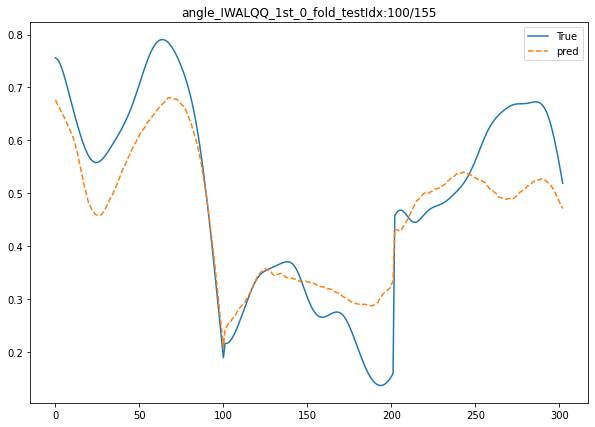

In [56]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

figure(figsize=(10, 7))
xpoints = np.array([_ for _ in range(0,303)])
ypoints = np.array(Y_angle_test)
ypoints_2 = np.array(result_angle)

plt.plot(xpoints, ypoints,label='True')
plt.plot(xpoints, ypoints_2,'--',label="pred")
plt.legend()
plt.title(f"angle_{nameDataset}_{numFold}_fold_testIdx:{dataIndex}/{len(load_test['final_X_test'])}")
plt.show()

### 데이터 복구하기

In [57]:
y_true = Y_angle_test
y_pred = result_angle
y_true = np.transpose(np.reshape(np.squeeze(y_true), [3,-1])) # 수정 !!!!
y_pred = np.transpose(np.reshape(np.squeeze(y_pred), [3,-1])) # 수정 !!!!
y_true_pick_afterscaler = (y_true - load_scaler4Y_angle.min_) / load_scaler4Y_angle.scale_
y_pred_pick_afterscaler = (y_pred - load_scaler4Y_angle.min_) / load_scaler4Y_angle.scale_

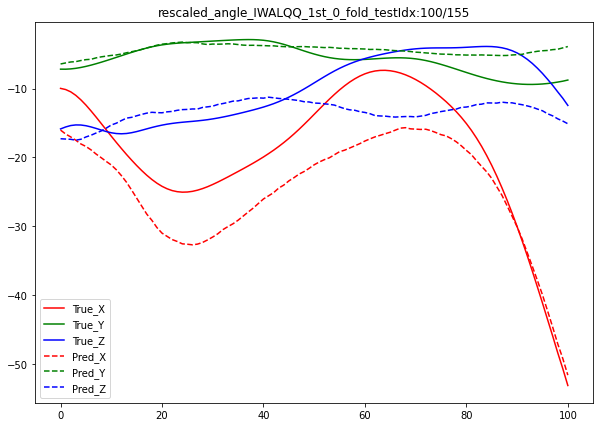

<Figure size 640x480 with 0 Axes>

In [58]:
# 실제 데이터
from cycler import cycler
cy = cycler('color', ['red',  'green', 'blue'])

f, ax = plt.subplots(figsize=(10,7))
ax.set_prop_cycle(cy)
figure(figsize=(8, 6), dpi=80)

xpoints = np.array([_ for _ in range(0,101)])
ypoints = np.array(y_true_pick_afterscaler)
ypoints_2 = np.array(y_pred_pick_afterscaler)

ax.plot(xpoints, ypoints,label=('True_X','True_Y','True_Z'))
ax.plot(xpoints, ypoints_2,'--',label=('Pred_X','Pred_Y','Pred_Z'))
ax.legend()
ax.set_title(f"rescaled_angle_{nameDataset}_{numFold}_fold_testIdx:{dataIndex}/{len(load_test['final_X_test'])}")
f.show()

# moment

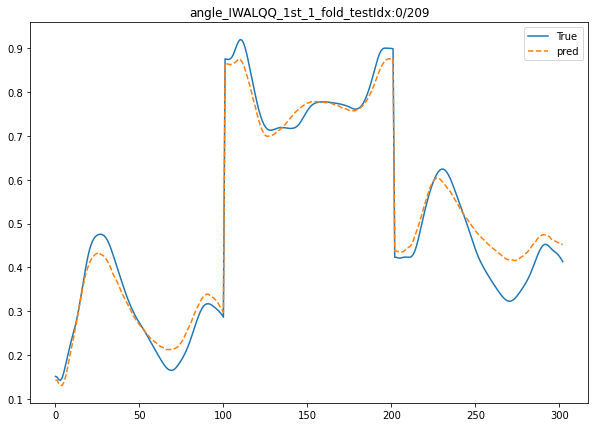

In [21]:
figure(figsize=(10, 7))
xpoints = np.array([_ for _ in range(0,303)])
ypoints = np.array(Y_moBWHT_test)
ypoints_2 = np.array(result_moBWHT)

plt.plot(xpoints, ypoints,label='True')
plt.plot(xpoints, ypoints_2,'--',label="pred")
plt.legend()
plt.title(f"angle_{dataset}_{numFold}_fold_testIdx:{dataIndex}/{len(load_test['final_X_test'])}")
plt.show()
## Q. 원래 데이터랑 추정 데이터랑 너무 크게 차이 나는게 아니냐??
## A. 이게 그 문제다! trainset에서만 scaler를 학습시켰는데, trainset과 testset의 데이터 분포가 크게 다르게되면 이런 문제가 나온다!
##    크-해석 좋았다..

In [22]:
y_true = Y_moBWHT_test
y_pred = result_moBWHT
y_true = tf.transpose(tf.reshape(tf.squeeze(y_true), [3,-1])) # 수정 !!!!
y_pred = tf.transpose(tf.reshape(tf.squeeze(y_pred), [3,-1])) # 수정 !!!!
y_true_pick_afterscaler = (y_true - K.constant(load_scaler4Y_moBWHT.min_)) / K.constant(load_scaler4Y_moBWHT.scale_)
y_pred_pick_afterscaler = (y_pred - K.constant(load_scaler4Y_moBWHT.min_)) / K.constant(load_scaler4Y_moBWHT.scale_)

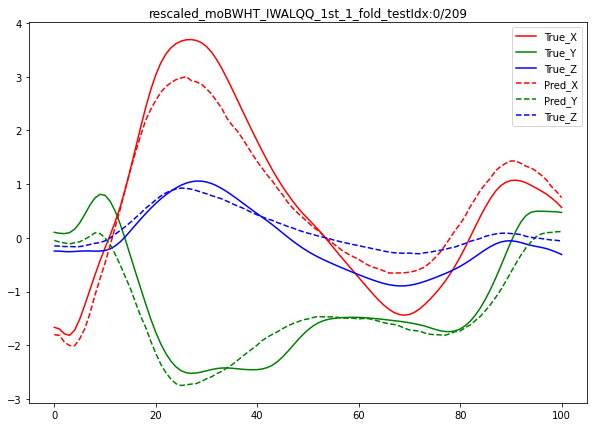

<Figure size 640x480 with 0 Axes>

In [23]:
cy = cycler('color', ['red',  'green', 'blue'])

f, ax = plt.subplots(figsize=(10,7))
ax.set_prop_cycle(cy)
figure(figsize=(8, 6), dpi=80)

xpoints = np.array([_ for _ in range(0,101)])
ypoints = np.array(y_true_pick_afterscaler)
ypoints_2 = np.array(y_pred_pick_afterscaler)

ax.plot(xpoints, ypoints,label=('True_X','True_Y','True_Z'))
ax.plot(xpoints, ypoints_2,'--',label=('Pred_X','Pred_Y','True_Z'))
ax.legend()
ax.set_title(f"rescaled_moBWHT_{dataset}_{numFold}_fold_testIdx:{dataIndex}/{len(load_test['final_X_test'])}")
f.show()